In [35]:
%matplotlib inline
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import sys

In [36]:
a2 = nx.read_edgelist("Avengers2_edge_list.txt", data=(('weight',float),))
a1 = nx.read_edgelist("Avengers1_edge_list.txt", data=(('weight',float),))
sm1 = nx.read_edgelist("Spider-Man_Homecoming_edge_list.txt", data=(('weight',float),))
tr = nx.read_edgelist("Thor_Ragnarok_edge_list.txt", data=(('weight',float),))

In [37]:
def standardize_names(g):

    new_names = {'BlackWidow':'Black_Widow',
             'Captin_America':'Captain_America','CaptainAmerica':'Captain_America',
             'Clint_Barton':'Hawkeye',
             'Iron_Man':'IronMan',
             'NickFury':'Nick_Fury',
             'ScarletWitch':'Scarlet_Witch',
             'WarMachine':'War_Machine'}

    fixes = set(new_names.keys()) - set(g.nodes())
    
    for fix in fixes:
        del new_names[fix]
        
    return nx.relabel_nodes(g, new_names)

In [38]:
a1 = standardize_names(a1)
a2 = standardize_names(a2)
sm1 = standardize_names(sm1)
tr = standardize_names(tr)

In [39]:
def combine_weighted_graphs(g,h):
    ''' Need special function to combined graphs with weighted edges where you want the weights of edges
    in both graphs to be added together'''
    
    combined = nx.Graph()

    # standardize edge name ordering
    g_edges = [tuple(sorted(x)) for x in g.edges]
    h_edges = [tuple(sorted(x)) for x in h.edges]
  
    add_weights_edges = set(g_edges) & set(h_edges)
    
    for edge in add_weights_edges:
        weight = g[edge[0]][edge[1]]['weight'] + h[edge[0]][edge[1]]['weight']
        combined.add_edge(edge[0], edge[1], weight=weight)
   
    # edges in g not in h
    unique_edges = set(g_edges) - set(h_edges)
    for edge in unique_edges:
        combined.add_edge(edge[0],edge[1], weight=g[edge[0]][edge[1]]['weight'])

    # edges in h not in g
    unique_edges = set(h_edges) - set(g_edges)
    for edge in unique_edges:
        combined.add_edge(edge[0],edge[1], weight=h[edge[0]][edge[1]]['weight'])
                       
    return combined

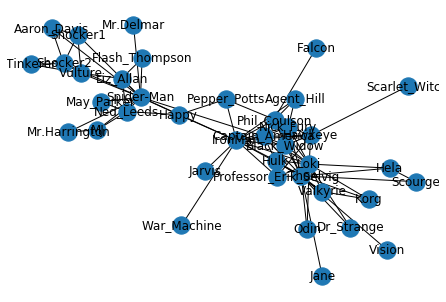

In [40]:
combined = combine_weighted_graphs(a1, a2)
c2 = combine_weighted_graphs(combined, sm1)
c3 = combine_weighted_graphs(c2,tr)
nx.draw_spring(c3, with_labels = True)

In [67]:

#returns Common Neighbr Distance for given nodes x and y 
def common_neighbor_distance (g, x, y) :
    cn = len(list(nx.common_neighbors(g, x, y)))
    if(cn > 0):
        return (1 + cn)/2
    else:
        return 1/nx.shortest_path_length(g, source = x, target = y)
    
#returns Sorenson Index for given nodes x and y
def sorenson_index (g, x, y) :
    cn = len(list(nx.common_neighbors(g, x, y)))
    return 2*cn/(g.degree(x)+g.degree(y))

#Similarity between two nodes using the Hub Promoted Index
def hpi(G,x,y):
    return len(list(nx.common_neighbors(G, x, y)))/min(G.degree(x),G.degree(y))   

#common neighbor and closeness (method proposed in paper)
def cnc(g, x, y, a):
    intersect = len(list(nx.common_neighbors(g, x, y)))
    return a*intersect + (1-a)*g.number_of_nodes()/nx.shortest_path_length(g, source = x, target = y)

In [73]:
#iterates through all pairs of nodes
#returns dataframe with all metric values for each pair
def metric_iterator (g) :
    df = pd.DataFrame(columns = ['first', 'second', 'CND', 'PA', 'AA', 'CN', 'SI', 'JI', 'RA', 'HPI', 'connected'])
    nodes = list(g)
    for x in range(0, g.number_of_nodes()):
        for y in range(x + 1, g.number_of_nodes()):
            #call 8 metrics and add to dataframe
            scores = dict()
            scores['first'] = nodes[x]
            scores['second'] = nodes[y]
            scores['CND'] = round(common_neighbor_distance(g, nodes[x], nodes[y]), 3)
            scores['PA'] = int(list(nx.preferential_attachment(g, [(nodes[x], nodes[y])]))[0][2])
            scores['AA'] = round(list(nx.adamic_adar_index(g, [(nodes[x], nodes[y])]))[0][2], 3)
            scores['CN'] = len(list(nx.common_neighbors(g, nodes[x], nodes[y])))
            scores['SI'] = round(sorenson_index(g, nodes[x], nodes[y]), 3)
            scores['JI'] = round(list(nx.jaccard_coefficient(g, [(nodes[x], nodes[y])]))[0][2], 3)
            scores['RA'] = round(list(nx.resource_allocation_index(g, [(nodes[x], nodes[y])]))[0][2], 3)
            scores['HPI'] = round(hpi(g, nodes[x], nodes[y]), 3)
            #scores['CNC'] = cnc(g, nodes[x], nodes[y], .5) # setting a = 0.5
            scores['connected'] = g.has_edge(nodes[x], nodes[y])
            newRow = pd.Series(data = scores, name = "" + nodes[x] + "," + nodes[y])
            df = df.append(newRow, ignore_index = False)
            
    return df

In [69]:
#given list of recall and presicion, removes null points(0,0)
def remove_null_points (x, y) :
    arange = []
    for i in range(len(x)):
        if((x[i] == 0) and (y[i] == 0)):
            arange.append(i)
    x = np.delete(x, arange, 0)
    y = np.delete(y, arange, 0)
    return x, y

In [70]:
#function metric_evaluation
#parameter g, graph to evaluate similarity metrics on 
def metric_evaluation(g):

    df = metric_iterator(g)
    metric_frame = df.drop(['first', 'second'], axis = 1)
    data = []

    for column in metric_frame.columns:
        #normalize our metrics
        if(column != "connected"):
            x = df[[column]].values.astype(float)
            min_max_scaler = preprocessing.MinMaxScaler()
            x_scaled = min_max_scaler.fit_transform(x)
            df_normalized = pd.DataFrame(x_scaled)
            #print(list(df_normalized[0]))
            precision, recall, thresholds = precision_recall_curve(list(df['connected']), list(df_normalized[0]))
            precision, recall = remove_null_points(precision, recall)
           # if(column == 'CNC'):
           #     print(precision)
           #     print(recall)
           #     print(thresholds)
            area = auc(recall, precision)
            data.append([column + ": " + "%.3f" % area, precision, recall])
    for index in data:
        plt.plot(index[2], index[1], label = index[0])
        # Put a legend to the right of the current axis
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title = 'AUC')
        plt.ylabel("Precision")
        plt.xlabel("Recall")
        plt.suptitle("Precision-Recall Curve")

In [71]:
def roc(g):
    
    df = metric_iterator(g)
    metric_frame = df.drop(['first', 'second'], axis = 1)
    data = []

    for column in metric_frame.columns:
        #normalize our metrics
        if(column != "connected"):
            x = df[[column]].values.astype(float)
            min_max_scaler = preprocessing.MinMaxScaler()
            x_scaled = min_max_scaler.fit_transform(x)
            df_normalized = pd.DataFrame(x_scaled)
            dflist = list(df['connected'])
            dfnorm = list(df_normalized[0])
            fpr, tpr, thresholds = roc_curve(dflist, dfnorm)
            fpr, tpr = remove_null_points(fpr,tpr)
            #roc_auc = metrics.auc(fpr, tpr)
           # if(column == 'CNC'):
           #     print(fpr)
           #     print(tpr)
           #     print(thresholds)
            area = auc(tpr, fpr)
            data.append([column + ": " + "%.3f" % area, fpr, tpr])


    for index in data:
        plt.plot(index[2], index[1], label = index[0])
        # Put a legend to the right of the current axis
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title = 'AUC')
        plt.ylabel("True Positive Rate")
        plt.xlabel("False Positive Rate")
        plt.suptitle("Receiver Operating Characteristic (ROC) Curve")

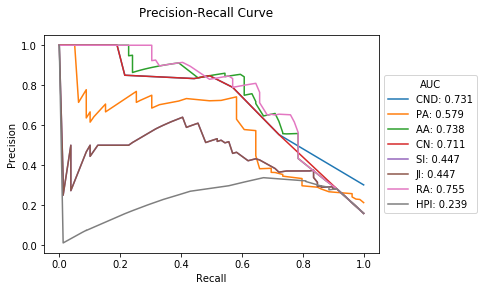

In [74]:
metric_evaluation(c2)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00719424 0.01678657
 0.02877698 0.11031175 0.43884892 0.87769784 0.99280576 1.        ]
[0.01265823 0.08860759 0.18987342 0.21518987 0.44303797 0.49367089
 0.56962025 0.72151899 0.91139241 1.         1.         1.
 1.         1.         1.         1.         1.         1.        ]
[2.         1.         0.97109827 0.94219653 0.9132948  0.88439306
 0.85549133 0.8265896  0.79768786 0.76878613 0.73988439 0.45086705
 0.42196532 0.36416185 0.33526012 0.30635838 0.12331407 0.04624277
 0.        ]


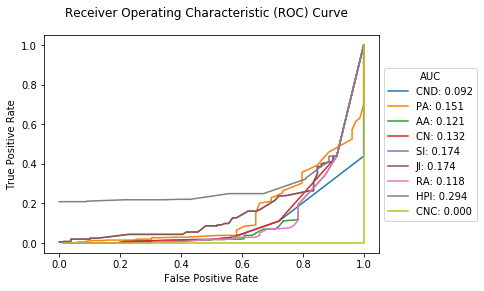

In [61]:
roc(c2)

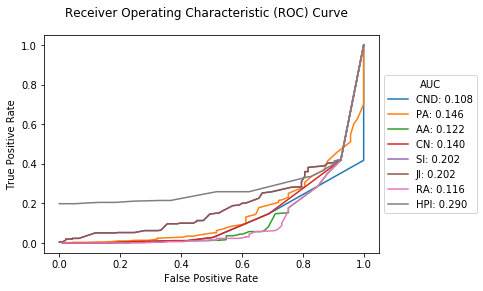

In [75]:
roc(c3)

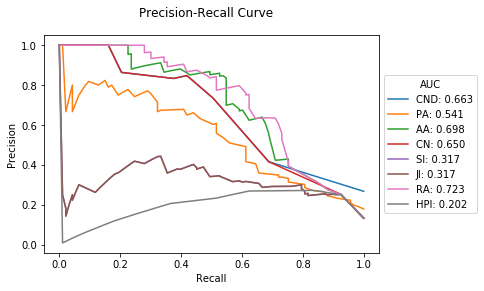

In [77]:
metric_evaluation(c3)

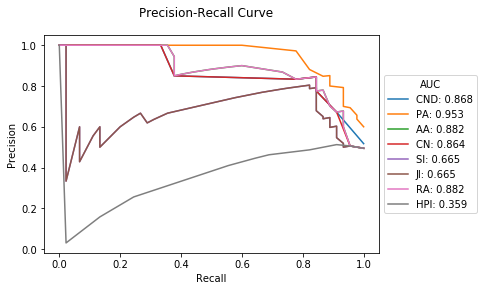

In [78]:
metric_evaluation(a1)

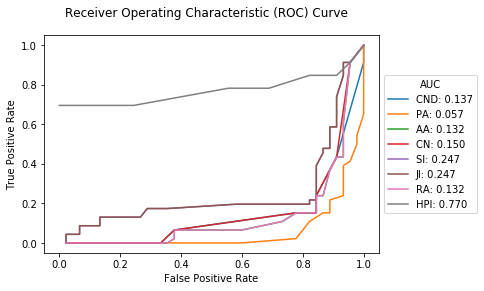

In [50]:
roc(a1)

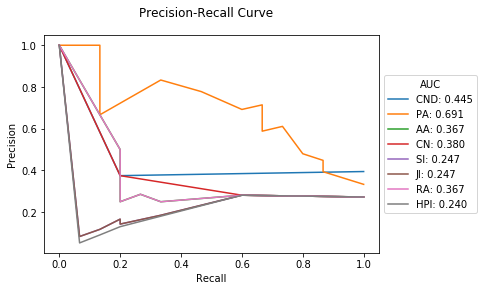

In [79]:
metric_evaluation(a2)

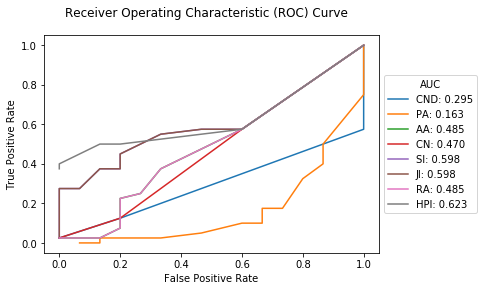

In [52]:
roc(a2)

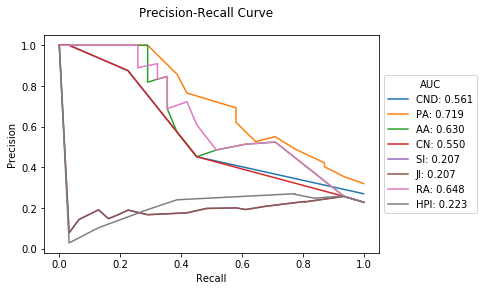

In [80]:
metric_evaluation(sm1)

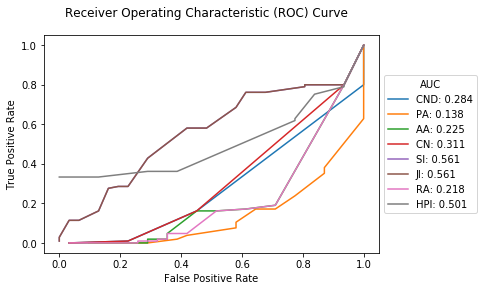

In [54]:
roc(sm1)

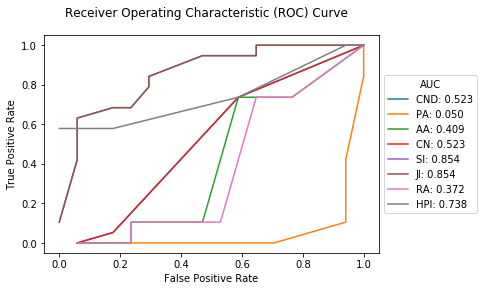

In [55]:
roc(tr)

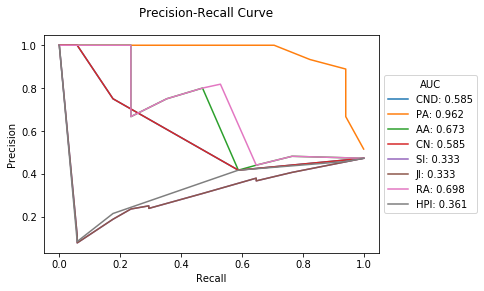

In [81]:
metric_evaluation(tr)